It's possible to analyze what a network detects by visualizing the type of patterns that a particular class prediction is likely to produce. In this notebook, you find an implementation of the proposed approach by 
Simonyan et al. (2014) in their paper "Visualising
image classification models and saliency maps" and further developed by Yosinski et al. (2015) in their paper "Understanding Neural Networks Through Deep Visualization".

In [10]:
import torch
import torchvision
from torchvision import transforms
import random
import numpy as np
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt
from PIL import Image
import os
from torch.autograd import grad

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'viridis'

In [11]:
model = torchvision.models.squeezenet1_1(pretrained=True)
model.eval()
for param in model.parameters():
    param.requires_grad = False

In [12]:
SQUEEZENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
SQUEEZENET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)

def preprocess(img, size=224):
    transform = transforms.Compose([
        transforms.Scale(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        transforms.Lambda(lambda x: x[None]),  # add one dimension
    ])
    return transform(img)

def deprocess(img, should_rescale=True):
    transform = transforms.Compose([
        transforms.Lambda(lambda x: x[0]),
        transforms.Normalize(mean=[0, 0, 0], std=(1.0 / SQUEEZENET_STD).tolist()),
        transforms.Normalize(mean=(-SQUEEZENET_MEAN).tolist(), std=[1, 1, 1]),
        transforms.Lambda(rescale) if should_rescale else transforms.Lambda(lambda x: x),
        transforms.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled

def jitter(X, ox, oy):
    """
    Helper function to randomly jitter an image.
    
    Inputs
    - X: PyTorch Tensor of shape (N, C, H, W)
    - ox, oy: Integers giving number of pixels to jitter along W and H axes
    
    Returns: A new PyTorch Tensor of shape (N, C, H, W)
    """
    if ox != 0:
        left = X[:, :, :, :-ox]
        right = X[:, :, :, -ox:]
        X = torch.cat([right, left], dim=3)
    if oy != 0:
        top = X[:, :, :-oy]
        bottom = X[:, :, -oy:]
        X = torch.cat([bottom, top], dim=2)
    return X

def blur_image(X, sigma=1):
    X_np = X.cpu().clone().detach().numpy()
    X_np = gaussian_filter1d(X_np, sigma, axis=2)
    X_np = gaussian_filter1d(X_np, sigma, axis=3)
    X.copy_(torch.Tensor(X_np).type_as(X))
    return X

We can visualize the class by starting with an initial image x (random noise, in our case), and modifying it image such as to maximize the score for a chosen target class i. 
Regularization techniques are used to improve the quality of the results:

- Adding an L2 norm of the image as a regularization loss. 
- Applying implicit regularization to the image we’re modifying, using translations and blurs.

Formally, for an image x that we want to modify to classify it in class i, we maximize the following loss:

$L = y_i − λ||x||_2.$ 


We progressively modify x with the following rule:

$x ← x + η∇_xL$  (η is the learning rate).

In [13]:
def create_class_visualization(target_y, model, dtype, init_img=None, l2_reg=1e-3, learning_rate=5,
                               num_iterations=200, blur_every=10, max_jitter=16, show_every=25):
    """
    Generate an image to maximize the score of target_y under a pretrained model.
    
    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    - dtype: Torch datatype to use for computations
    
    Keyword arguments:
    - init_img: Initial image to use (if None, will be random)
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    model.type(dtype)

    # Randomly initialize the image as a PyTorch Tensor
    if init_img is None:
        img = torch.randn(1, 3, 224, 224).mul_(1.0).type(dtype).detach()
    else:
        img = init_img.clone().mul_(1.0).type(dtype).detach()
    img.requires_grad = True

    for t in range(num_iterations):
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = random.randint(0, max_jitter), random.randint(0, max_jitter)
        img = (jitter(img, ox, oy)).clone().detach()
        img.requires_grad = True

        yhat = model(img)
        L = yhat - l2_reg * img.norm(p=2)
        g = grad(L[0][target_y], img, retain_graph=True)[0]
        img = img+learning_rate* g
        
        # Undo the random jitter
        img.data.copy_(jitter(img, -ox, -oy))

        # As regularizer, clamp and periodically blur the image
        for c in range(3):
            lo = float(-SQUEEZENET_MEAN[c] / SQUEEZENET_STD[c])
            hi = float((1.0 - SQUEEZENET_MEAN[c]) / SQUEEZENET_STD[c])
            img[:, c].clamp_(min=lo, max=hi)
        if t % blur_every == 0:
            blur_image(img, sigma=0.5)
        
        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            plt.imshow(deprocess(img.clone().cpu()))
            class_name = class_names[target_y]
            plt.title('%s\nIteration %d / %d' % (class_name, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            plt.show()

    return deprocess(img.cpu())

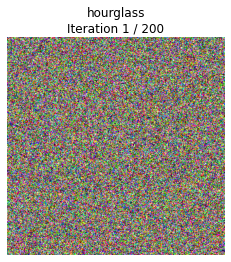

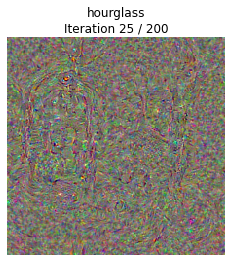

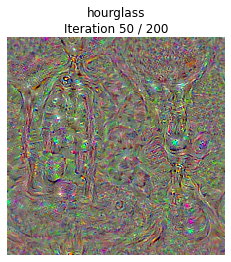

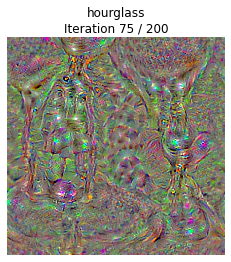

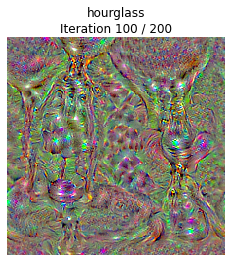

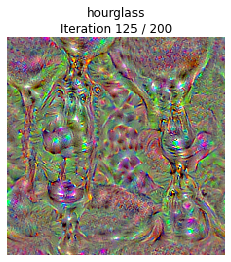

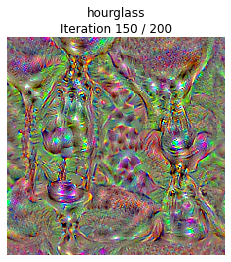

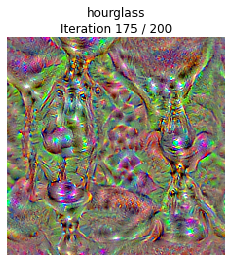

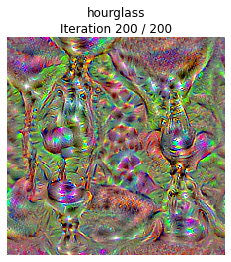

In [14]:
out = create_class_visualization(604, model, torch.FloatTensor, show_every=25, num_iterations=200) # 604 is the hourglass class.